In [19]:

import torch
import torch.nn as nn

import matplotlib.pyplot as plt

device = "cuda" if torch.cuda.is_available() else "cpu"


class RBF_Add(nn.Module):
    def __init__(self, add_rbf_number, device = device):
        super(RBF_Add, self).__init__()

        self.add_rbf_number = add_rbf_number
        self.radial_layer_centers_list = []
        self.radial_sigma_list = []
        self.linear_layer_weights_list = []
        
        
        self.total_radial_layer_centers_list = []
        self.total_radial_sigma_list = []
        self.total_linear_layer_weights_list = []
        
        self.change_th = 3

    def rbf_gaussian(self, input_data):
        output = torch.exp(-1 * (torch.pow((input_data - self.radial_layer_centers), 2) / \
                                 (torch.pow(self.radial_sigma, 2))))

        return output  # size = (num_rbf, 1)

    def done_rbf_gaussian(self, input_data, number):
        output = torch.exp(-1 * (torch.pow(
            (input_data - self.done_radial_layer_centers[number - 1 - self.add_rbf_number:number - 1]), 2) / \
                                 (torch.pow(self.done_radial_sigma[number - 1 - self.add_rbf_number:number - 1], 2))))

        return output  # size = (num_rbf, 1)

    def rbf_gaussian_derivative_centers(self, input_data):
        output = (2 * (input_data - self.radial_layer_centers) / \
                  (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_centers2(self, input_data):
        output = (2 / (torch.pow(self.radial_sigma, 2))) * self.rbf_gaussian(input_data) + \
                ((-2* (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * \
                 self.rbf_gaussian_derivative_centers(input_data))

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_sigma(self, input_data):
        output = (2 * torch.pow((input_data - self.radial_layer_centers), 2) / \
                  (torch.pow(self.radial_sigma, 3))) * self.rbf_gaussian(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gaussian_derivative_sigma2(self, input_data):
        output = (4 * (input_data - self.radial_layer_centers) / (torch.pow(self.radial_sigma, 3))) * \
                    self.rbf_gaussian(input_data) + (-2*(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)) * \
                    self.rbf_gaussian_derivative_sigma(input_data)

        return output  # size = (num_radial, 1)
    '''
    def rbf_gradient(self, input_data, centers, sigmas, weights):
        rbf_output = (-2 * (input_data-centers) / torch.pow(sigmas,2)) * \
                        (torch.exp(-1 * (torch.pow((input_data - centers), 2) / (torch.pow(sigmas, 2)))))
        rbf_grad = torch.mm(weights, rbf_output)
        
        return rbf_grad
    
    def first_grad(self, input_data, target):
        space = (input_data,)
        f_grad = torch.gradient(target[0], spacing = space, edge_order  = 1)
        return f_grad[0]
    
    def target_grad(self, input_data, centers, sigmas, weights, f_grad):
        true_grad = f_grad - self.rbf_gradient(input_data, centers, sigmas, weights)
        
        return true_grad
    
    def Loss(self, pred, target, pred_grad, true_grad):
        
        return torch.mean(torch.pow(target - pred,2) + torch.pow(true_grad - pred_grad, 2))

    def forward(self, input_data):
        rbf_output = self.rbf_gaussian(input_data)
        pred = torch.mm(self.linear_layer_weights, rbf_output)

        return rbf_output, pred

    def pred(self, input_data):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - self.done_radial_layer_centers), 2) / \
                                     (torch.pow(self.done_radial_sigma, 2))))
        pred = torch.mm(self.done_linear_layer_weights, rbf_output)

        return rbf_output, pred
    
    def L2_F(self, input_data):
        return -2 * (input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma, 2)
    

    def first_rbf_parameter(self, input_data, target):
        
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        fine_index_target = target.clone().detach()
        find_sigma = target.clone().detach()
        
        target_std = target.std()
        
        find_weight = target.clone().detach()
        center_index_list = []

        for i in range(self.add_rbf_number):
            index_ = torch.argmax(torch.abs(fine_index_target)).cpu().detach().tolist()
            fine_index_target[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)
                            

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        dft =  torch.abs(dft / torch.max(dft)) **-1
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))
    
        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def init_rbf_parameter(self, input_data, error):
        time_interval = int((torch.max(input_data.diff(1)) / torch.min(input_data.diff(1)).item()))
        find_index_input = input_data.clone().detach()
        find_index_error = error.clone().detach()
        
        find_weight = error.clone().detach()
        find_sigma = error.clone().detach()
        
        target_std = error.std()
        center_index_list = []

        for i in range(self.add_rbf_number * (self.change_time + 1)):
            index_ = torch.argmax(torch.abs(find_index_error)).cpu().detach().tolist()

            find_index_error[index_] = 0
            center_index_list.append(index_)

        center_index_list = torch.tensor(center_index_list, device=device)
        initcenter = torch.index_select(find_index_input, 0, center_index_list)
        initweight = torch.index_select(find_weight, 0, center_index_list)

        sigma_list = []
        dft = torch.log(torch.abs(torch.fft.fft(find_sigma).real))
        
        dft =  (torch.abs(dft / torch.max(dft))**-1)
        for k in center_index_list:
            sigma_list.append(dft[k].reshape(1))

        initsigma = torch.cat(sigma_list)

        return initcenter[-self.add_rbf_number:], initweight[-self.add_rbf_number:], initsigma[-self.add_rbf_number:]

    def change_init(self, na):
        if na == 1:
            loss_list = self.train_loss_list[-self.change_th:]
            if self.number > self.change_th and max(loss_list) == min(loss_list):
                self.change_time += 1
            elif self.number > self.change_th and loss_list[0] < loss_list[1] and loss_list[1] < loss_list[2]:
                self.change_time += 1
            else:
                self.change_time = 0
        else:
            self.change_time += 1

    def best_forward(self, input_data, best_center, best_sigma, best_weight):
        rbf_output = torch.exp(-1 * (torch.pow((input_data - best_center), 2) / \
                                     (torch.pow(best_sigma, 2))))
        pred = torch.mm(best_weight, rbf_output)

        return rbf_output, pred    
    
    def L2_2_derivateive_weight(self, input_data, radial_output):
        return (-2 *(input_data - self.radial_layer_centers) / torch.pow(self.radial_sigma,2)) * radial_output

    def backward_propagation(self, input_data, radial_output, pred, target, target_grad, pred_grad):
        
        L2_1_error = -2 * (target - pred)
        print(pred)
        print(torch.mean(L2_1_error))

        L2_2_error = -2 * (target_grad - pred_grad)
        print(torch.mean(L2_2_error))
        len_ = len(L2_2_error)

        # sigma update
        deltaSigma1 = self.rbf_gaussian_derivative_sigma(input_data) * L2_1_error
        deltaSigma1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        print('deltasigma1')
        print(torch.sum(deltaSigma1, dim=1))
        print('--------------------')
        deltaSigma2 = self.rbf_gaussian_derivative_sigma(input_data) * L2_2_error
        deltaSigma2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        print('deltasigma2')
        print(torch.sum(deltaSigma2, dim=1))
        print('--------------------')
        deltaSigma =  torch.sum(deltaSigma1, dim=1) + torch.sum(deltaSigma2, dim=1)
        print('deltasigma')
        print(deltaSigma)
        print('--------------------')
        # center update
        deltaCenter1 = self.rbf_gaussian_derivative_centers(input_data) * L2_1_error
        deltaCenter1 *= self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        print('deltacenter1')
        print(torch.sum(deltaCenter1, dim=1))
        print('--------------------')
        
        deltaCenter2 = self.rbf_gaussian_derivative_centers(input_data) * L2_2_error
        deltaCenter2 *= self.L2_F(input_data) * self.linear_layer_weights.reshape(self.add_rbf_number, 1)
        print('deltacenter2')
        print(torch.sum(deltaCenter2, dim=1))
        print('--------------------')
        deltaCenter =  torch.sum(deltaCenter1, dim=1) + torch.sum(deltaCenter2, dim=1)
        print('deltacenter')
        print(deltaCenter)
        print('--------------------')
        # weight update
        delta_weight1 = torch.sum((radial_output * L2_1_error), dim=1)
        delta_weight1 = delta_weight1.reshape(1, self.add_rbf_number)
        print('deltaweight1')
        print(delta_weight1)
        print('--------------------')
        delta_weight2 = torch.sum((self.L2_2_derivateive_weight(input_data, radial_output) * L2_2_error), dim = 1)
        delta_weight2 = delta_weight2.reshape(1, self.add_rbf_number)
        print('deltaweight2')
        print(delta_weight2)
        print('--------------------')
        delta_weight = delta_weight1 + delta_weight2
        print('deltaweight')
        print(delta_weight)
        print('--------------------')
        # BP update
        self.linear_layer_weights -= self.lr * delta_weight
        #self.radial_layer_centers -= self.lr * torch.sum(deltaCenter1, dim=1).reshape(self.add_rbf_number, 1)
        #self.radial_sigma -= self.lr * torch.sum(deltaSigma1, dim=1).reshape(self.add_rbf_number, 1)
        self.radial_layer_centers -= self.lr * deltaCenter.reshape(self.add_rbf_number, 1)
        self.radial_sigma -= self.lr * deltaSigma.reshape(self.add_rbf_number, 1)
        
    def train(self, input_data, target, epochs, lr, loss_th, lr_change_th):
        self.lr = lr

        self.target = target.clone().detach()
        self.number = 0
        self.train_loss_list = []
        self.loss_th = loss_th
        self.change_time = 0
        self.round_number = 5
        self.target_mape_th = torch.mean(torch.abs(target)) * 0.05
        self.lr_change_th = lr_change_th
        count_loss_chage = 0
        count_round_change = 0

        break_time = len(input_data) / self.add_rbf_number
        loss = 100000

        while self.loss_th < loss:
            print(self.number)
            # first rbf
            if self.number == 0:
                cent, weig, sig = self.first_rbf_parameter(input_data, self.target[0])
                print('initial parameters')
                print(cent)
                print(weig)
                print(sig)
                print('----------------------')
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)
                first_grad = self.first_grad(input_data, target)
                for epo in range(epochs):
                    print("epoch : {}".format(epo))
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    self.backward_propagation(input_data, radial_output, pred, self.target, first_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, first_grad)
                    if epo == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    else:
                        if self.best_loss > epo_loss:
                            self.best_loss = epo_loss.clone().detach()
                            self.best_center = self.radial_layer_centers.clone().detach()
                            self.best_sigma = self.radial_sigma.clone().detach()
                            self.best_weight = self.linear_layer_weights.clone().detach()
                    if (epo + 1) % 250 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

            # additional rbf
            else:
                # init parameter
                self.change_init(na)
                if self.change_time > break_time:
                    break
                cent, weig, sig = self.init_rbf_parameter(input_data, self.target[0])
                print('additional parameters')
                print(cent)
                print(weig)
                print(sig)
                print('----------------------')
                self.radial_layer_centers = cent.reshape(self.add_rbf_number, 1)
                self.radial_sigma = sig.reshape(self.add_rbf_number, 1)
                self.linear_layer_weights = weig.reshape(1, self.add_rbf_number)

                for epo in range(epochs):
                    print("epoch : {}".format(epo))
                    radial_output, pred = self.forward(input_data)
                    rbf_grad = self.rbf_gradient(input_data, self.radial_layer_centers, self.radial_sigma, self.linear_layer_weights)
                    
                    if epo == 0:
                        print(self.Loss(pred, self.target, rbf_grad, target_grad))
                        self.best_loss = self.Loss(pred, self.target, rbf_grad, target_grad).clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
                    self.backward_propagation(input_data, radial_output, pred, self.target, target_grad, rbf_grad)
                    epo_loss = self.Loss(pred, self.target, rbf_grad, target_grad)

                    if (epo + 1) % 1000 == 0:
                        print("{} epoch MSE Loss: {}".format(epo, epo_loss))

                    # best parameter
                    if self.best_loss > epo_loss:
                        self.best_loss = epo_loss.clone().detach()
                        self.best_center = self.radial_layer_centers.clone().detach()
                        self.best_sigma = self.radial_sigma.clone().detach()
                        self.best_weight = self.linear_layer_weights.clone().detach()
                    
            radial_output, best_pred = self.best_forward(input_data, self.best_center, self.best_sigma,
                                                         self.best_weight)
            best_grad = self.rbf_gradient(input_data, self.best_center, self.best_sigma, self.best_weight)
            if self.number ==0:
                train_loss = self.Loss(best_pred, self.target, best_grad, first_grad)
            else:
                train_loss = self.Loss(best_pred, self.target, best_grad, target_grad)

            print('train_loss', train_loss)
            print("best loss : ", self.best_loss)

            if self.best_loss < self.lr_change_th:
                count_loss_chage += 1
                self.lr *= 10
                self.lr_change_th *= 0.03
                print("change lr ", self.lr)
                print('----------------------------------------------')

            if count_round_change == 0 and train_loss < self.target_mape_th:
                count_round_change += 1
                self.round_number += 1
                print("change round number", self.round_number)
                print('----------------------------------------------')

            self.train_loss_list.append(torch.round(train_loss * (10 ** self.round_number)) / 10 ** self.round_number)

            # additional rbf plot print
            plt.figure(figsize=(10, 5))
            plt.plot(input_data.cpu().detach().numpy(), self.target[0].cpu().detach().numpy())
            plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
            plt.show()

            if torch.isnan(train_loss) == False:
                na = 1
                self.target = self.target - best_pred  # target update
                loss = train_loss  # loss update
                self.number += 1  # additional rbf number update
                self.radial_layer_centers_list.append(self.best_center)
                self.radial_sigma_list.append(self.best_sigma)
                self.linear_layer_weights_list.append(self.best_weight)

                self.done_radial_layer_centers = torch.cat(self.radial_layer_centers_list, 0)
                self.done_radial_sigma = torch.cat(self.radial_sigma_list, 0)
                self.done_linear_layer_weights = torch.cat(self.linear_layer_weights_list, 1)
                target_grad = self.target_grad(input_data, self.done_radial_layer_centers, self.done_radial_sigma, self.done_linear_layer_weights, first_grad)
            else:
                na = 0

In [11]:
import numpy as np
a = np.arange(0,10,0.05)
    
y = 2*a**3 - 16*a**2 + 2*a -10
y2 = 3*a**2 -16*a - 30
y3 = 5*a**2 +25*a - a**3

target = np.array((y,y2,y3))
target = torch.tensor(target, device = device).reshape((3,200))
input_ = torch.tensor(a, device = device)
single_target = torch.tensor(np.array(y), device = device, dtype=float).reshape(1,200)

In [12]:
def plot_train(input_data, in_feature, target): #done
    if in_feature != 1:
        fig, ax = plt.subplots(1, in_feature, figsize = (30, 5))
        for i in range(in_feature):
            ax[i].plot(input_data.cpu().detach().numpy(), target[i].cpu().detach().numpy())
            #ax[i].plot(input_data.cpu().detach().numpy(), best_pred[i].cpu().detach().numpy())
        plt.show()
    
    else:
        plt.plot(input_data.cpu().detach().numpy(), target[0].cpu().detach().numpy())
        #plt.plot(input_data.cpu().detach().numpy(), best_pred[0].cpu().detach().numpy())
        plt.show()

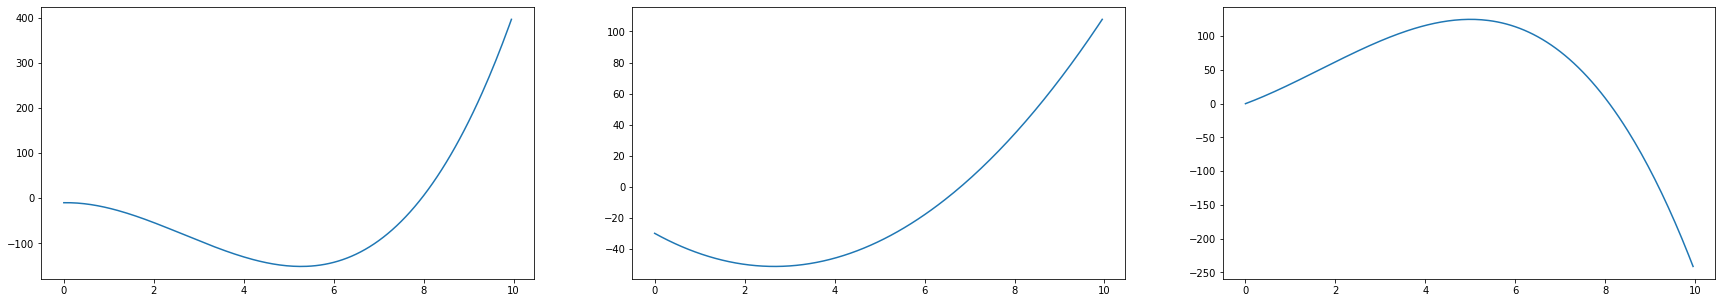

In [13]:
plot_train(input_, 3, target)

0
initial parameters
tensor([9.9500, 9.9000, 9.8500, 9.8000, 9.7500], device='cuda:0',
       dtype=torch.float64)
tensor([396.0098, 382.2380, 368.6833, 355.3440, 342.2188], device='cuda:0',
       dtype=torch.float64)
tensor([1.0000, 1.1765, 1.3219, 1.4643, 1.6227], device='cuda:0',
       dtype=torch.float64)
----------------------
epoch : 0
tensor([[7.1792e-14, 1.0387e-13, 1.4999e-13, 2.1617e-13, 3.1097e-13, 4.4651e-13,
         6.3989e-13, 9.1529e-13, 1.3067e-12, 1.8621e-12, 2.6484e-12, 3.7596e-12,
         5.3269e-12, 7.5333e-12, 1.0634e-11, 1.4981e-11, 2.1066e-11, 2.9567e-11,
         4.1419e-11, 5.7913e-11, 8.0822e-11, 1.1258e-10, 1.5652e-10, 2.1720e-10,
         3.0083e-10, 4.1587e-10, 5.7383e-10, 7.9028e-10, 1.0863e-09, 1.4904e-09,
         2.0410e-09, 2.7898e-09, 3.8060e-09, 5.1825e-09, 7.0436e-09, 9.5551e-09,
         1.2938e-08, 1.7484e-08, 2.3585e-08, 3.1754e-08, 4.2672e-08, 5.7236e-08,
         7.6627e-08, 1.0240e-07, 1.3657e-07, 1.8181e-07, 2.4159e-07, 3.2041e-07,
      

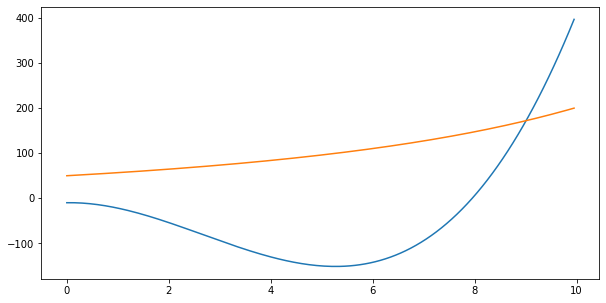

1
additional parameters
tensor([5.7000, 5.7500, 5.6500, 5.8000, 5.6000], device='cuda:0',
       dtype=torch.float64)
tensor([-253.4695, -253.4344, -253.4198, -253.3131, -253.2867],
       device='cuda:0', dtype=torch.float64)
tensor([2.0992, 2.0992, 2.0991, 2.0993, 2.0990], device='cuda:0',
       dtype=torch.float64)
----------------------
epoch : 0
tensor(320137.9566, device='cuda:0', dtype=torch.float64)
tensor([[-8.0780e-01, -9.1857e-01, -1.0433e+00, -1.1837e+00, -1.3415e+00,
         -1.5185e+00, -1.7170e+00, -1.9392e+00, -2.1877e+00, -2.4653e+00,
         -2.7749e+00, -3.1199e+00, -3.5038e+00, -3.9304e+00, -4.4041e+00,
         -4.9292e+00, -5.5107e+00, -6.1539e+00, -6.8643e+00, -7.6481e+00,
         -8.5117e+00, -9.4622e+00, -1.0507e+01, -1.1654e+01, -1.2911e+01,
         -1.4288e+01, -1.5794e+01, -1.7438e+01, -1.9232e+01, -2.1187e+01,
         -2.3314e+01, -2.5626e+01, -2.8134e+01, -3.0854e+01, -3.3798e+01,
         -3.6981e+01, -4.0418e+01, -4.4125e+01, -4.8117e+01, -5.2410e+

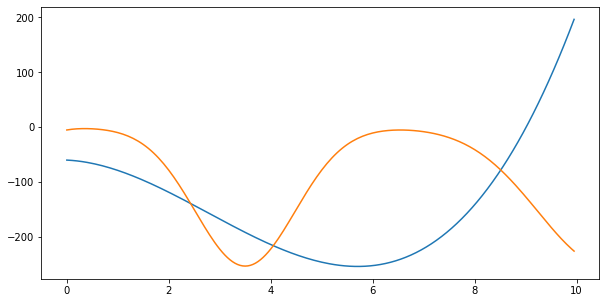

2
additional parameters
tensor([9.9500, 9.9000, 9.8500, 9.8000, 9.7500], device='cuda:0',
       dtype=torch.float64)
tensor([422.1158, 405.8710, 389.6080, 373.3412, 357.0855], device='cuda:0',
       dtype=torch.float64)
tensor([1.0000, 1.1483, 1.1177, 1.5384, 1.5170], device='cuda:0',
       dtype=torch.float64)
----------------------
epoch : 0
tensor(367365.7974, device='cuda:0', dtype=torch.float64)
tensor([[1.2957e-15, 1.9643e-15, 2.9715e-15, 4.4858e-15, 6.7575e-15, 1.0158e-14,
         1.5238e-14, 2.2810e-14, 3.4072e-14, 5.0787e-14, 7.5542e-14, 1.1213e-13,
         1.6608e-13, 2.4546e-13, 3.6203e-13, 5.3284e-13, 7.8256e-13, 1.1469e-12,
         1.6773e-12, 2.4478e-12, 3.5647e-12, 5.1803e-12, 7.5120e-12, 1.0870e-11,
         1.5697e-11, 2.2618e-11, 3.2523e-11, 4.6665e-11, 6.6815e-11, 9.5464e-11,
         1.3611e-10, 1.9364e-10, 2.7492e-10, 3.8948e-10, 5.5061e-10, 7.7674e-10,
         1.0934e-09, 1.5360e-09, 2.1530e-09, 3.0116e-09, 4.2037e-09, 5.8551e-09,
         8.1379e-09, 1.128

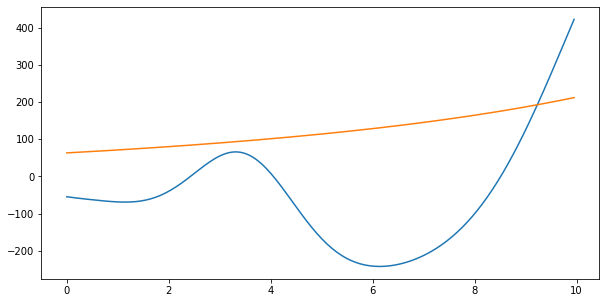

3
additional parameters
tensor([6.3500, 6.3000, 6.4000, 6.2500, 6.4500], device='cuda:0',
       dtype=torch.float64)
tensor([-374.2511, -374.2369, -374.0742, -374.0269, -373.7101],
       device='cuda:0', dtype=torch.float64)
tensor([2.0400, 2.0399, 2.0402, 2.0397, 2.0404], device='cuda:0',
       dtype=torch.float64)
----------------------
epoch : 0
tensor(689521.4164, device='cuda:0', dtype=torch.float64)
tensor([[-1.1844e-01, -1.3783e-01, -1.6020e-01, -1.8598e-01, -2.1566e-01,
         -2.4977e-01, -2.8892e-01, -3.3382e-01, -3.8523e-01, -4.4402e-01,
         -5.1117e-01, -5.8778e-01, -6.7505e-01, -7.7435e-01, -8.8720e-01,
         -1.0153e+00, -1.1605e+00, -1.3248e+00, -1.5106e+00, -1.7204e+00,
         -1.9570e+00, -2.2235e+00, -2.5232e+00, -2.8599e+00, -3.2376e+00,
         -3.6608e+00, -4.1344e+00, -4.6637e+00, -5.2544e+00, -5.9129e+00,
         -6.6459e+00, -7.4608e+00, -8.3656e+00, -9.3689e+00, -1.0480e+01,
         -1.1709e+01, -1.3066e+01, -1.4563e+01, -1.6212e+01, -1.8026e+

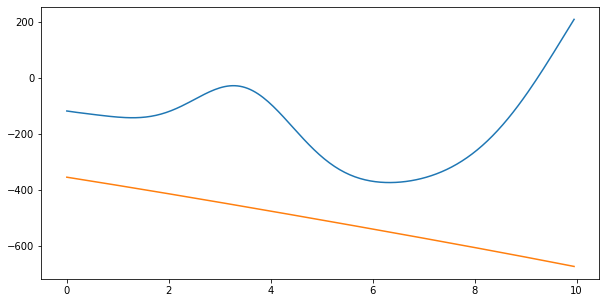

4
additional parameters
tensor([9.7000, 9.6500, 9.6000, 9.5500, 9.5000], device='cuda:0',
       dtype=torch.float64)
tensor([802.0361, 785.4237, 768.8616, 752.3658, 735.9521], device='cuda:0',
       dtype=torch.float64)
tensor([2.2267, 4.8894, 2.6213, 2.3055, 2.1819], device='cuda:0',
       dtype=torch.float64)
----------------------
epoch : 0
tensor(2353713.8056, device='cuda:0', dtype=torch.float64)
tensor([[  15.9743,   16.6307,   17.3105,   18.0142,   18.7428,   19.4967,
           20.2767,   21.0835,   21.9179,   22.7806,   23.6723,   24.5939,
           25.5460,   26.5294,   27.5451,   28.5937,   29.6761,   30.7931,
           31.9456,   33.1344,   34.3604,   35.6244,   36.9274,   38.2702,
           39.6537,   41.0789,   42.5467,   44.0580,   45.6138,   47.2150,
           48.8626,   50.5576,   52.3009,   54.0936,   55.9367,   57.8312,
           59.7781,   61.7786,   63.8337,   65.9444,   68.1118,   70.3372,
           72.6216,   74.9661,   77.3721,   79.8406,   82.3729,   8

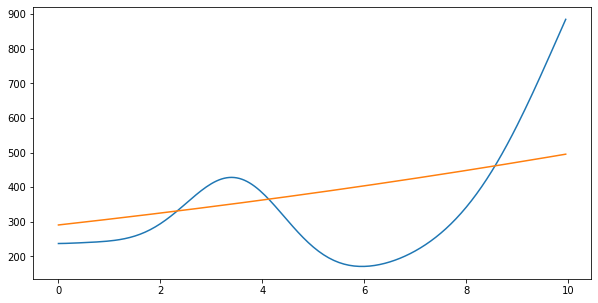

5
additional parameters
tensor([9.9500, 9.9000, 9.8500, 9.8000, 9.7500], device='cuda:0',
       dtype=torch.float64)
tensor([389.7992, 374.4161, 359.0048, 343.5797, 328.1558], device='cuda:0',
       dtype=torch.float64)
tensor([1.0000, 1.1473, 1.1088, 1.5559, 1.5156], device='cuda:0',
       dtype=torch.float64)
----------------------
epoch : 0
tensor(314818.0421, device='cuda:0', dtype=torch.float64)
tensor([[2.3716e-15, 3.5618e-15, 5.3384e-15, 7.9849e-15, 1.1919e-14, 1.7756e-14,
         2.6397e-14, 3.9164e-14, 5.7987e-14, 8.5682e-14, 1.2635e-13, 1.8593e-13,
         2.7306e-13, 4.0021e-13, 5.8537e-13, 8.5444e-13, 1.2447e-12, 1.8094e-12,
         2.6250e-12, 3.8006e-12, 5.4914e-12, 7.9181e-12, 1.1394e-11, 1.6363e-11,
         2.3450e-11, 3.3538e-11, 4.7868e-11, 6.8183e-11, 9.6920e-11, 1.3749e-10,
         1.9464e-10, 2.7498e-10, 3.8770e-10, 5.4550e-10, 7.6596e-10, 1.0733e-09,
         1.5009e-09, 2.0946e-09, 2.9172e-09, 4.0544e-09, 5.6234e-09, 7.7837e-09,
         1.0752e-08, 1.482

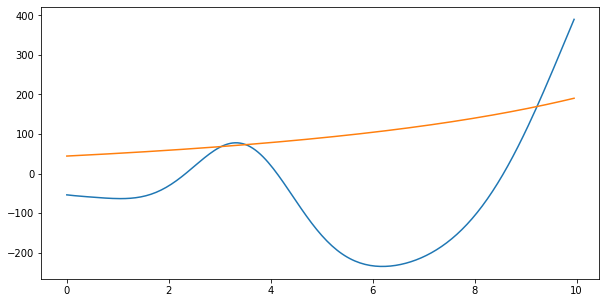

6
additional parameters
tensor([6.4000, 6.3500, 6.4500, 6.3000, 6.5000], device='cuda:0',
       dtype=torch.float64)
tensor([-343.4152, -343.3422, -343.3086, -343.0856, -343.0258],
       device='cuda:0', dtype=torch.float64)
tensor([2.0486, 2.0484, 2.0488, 2.0483, 2.0490], device='cuda:0',
       dtype=torch.float64)
----------------------
epoch : 0
tensor(582227.4678, device='cuda:0', dtype=torch.float64)
tensor([[-1.0123e-01, -1.1780e-01, -1.3691e-01, -1.5894e-01, -1.8429e-01,
         -2.1343e-01, -2.4688e-01, -2.8524e-01, -3.2917e-01, -3.7941e-01,
         -4.3679e-01, -5.0226e-01, -5.7686e-01, -6.6175e-01, -7.5823e-01,
         -8.6774e-01, -9.9189e-01, -1.1325e+00, -1.2914e+00, -1.4709e+00,
         -1.6734e+00, -1.9015e+00, -2.1581e+00, -2.4464e+00, -2.7700e+00,
         -3.1326e+00, -3.5384e+00, -3.9922e+00, -4.4987e+00, -5.0635e+00,
         -5.6924e+00, -6.3918e+00, -7.1687e+00, -8.0304e+00, -8.9850e+00,
         -1.0041e+01, -1.1208e+01, -1.2496e+01, -1.3915e+01, -1.5477e+

KeyboardInterrupt: 

In [20]:
model = RBF_Add(5, device)
model.train(input_,single_target, 5, 0.000001, 5, 100)